## Introduction

In this notebook, we performed the following steps:

1. **Data Import and Libraries**:
   - Imported necessary libraries such as [`pandas`], [`nltk`], and [`collections.Counter`].

2. **Negative Words List**:
   - Defined a set of negative words to identify negative sentiments in the reviews.

3. **N-grams Function**:
   - Created a function [`find_ngrams`] to generate bigrams and trigrams from the text.

4. **Filter Negative N-grams**:
   - Developed a function [`filter_negative_ngrams`] to filter out n-grams containing any of the negative words.

5. **Generate and Filter N-grams**:
   - Iterated through each review in the dataset to generate bigrams and trigrams.
   - Filtered these n-grams to retain only those containing negative words.

6. **Count N-grams**:
   - Used [`Counter`] to count the occurrences of each negative bigram and trigram.

7. **DataFrame Creation**:
   - Converted the counts of bigrams and trigrams into DataFrames.
   - Sorted these DataFrames by count and displayed the top 10 most frequent negative bigrams and trigrams.

This process helps in identifying common negative phrases in restaurant reviews, providing insights into areas that may need improvement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext as nt
import neattext.functions as nfx
import nltk
nltk.download('words')
from nltk.corpus import words
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bugra\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = pd.read_csv("restaurant.csv")
df.head()

Unnamed: 0               review_id                 user_id  \
0     2370338  _WTGv5XnA-qb_XD1D7Z0jg  6PgdGb3HrZdsfl2GiULo8w   
1     2370357  JlNnsvMPLK_1-X2hwzK24w  IS9yw8P2uAPBX6FNLLX4KA   
2     2370373  hBkoWffORRb6aqKhC_Li2A  uZdFsE_aHbFBChgN6Xa8tw   
3     2370411  rbkxvrgZg5kdCL2a66QYmA  8ZWJNAEWsymXDzKx3B0tTQ   
4     2370500  5tw_pedoHVi9bgeiBNsISg  E0sm4Ve7ifanFYeQMcV8Eg   

              business_id  stars  useful  funny  cool  \
0  RESDUcs7fIiihp38-d6_6g      5       0      1     0   
1  RESDUcs7fIiihp38-d6_6g      4      39     21    29   
2  RESDUcs7fIiihp38-d6_6g      4       1      1     1   
3  RESDUcs7fIiihp38-d6_6g      1       0      0     0   
4  RESDUcs7fIiihp38-d6_6g      5       0      0     0   

                                                text                 date  
0  After getting food poisoning at the Palms hote...  2012-12-04 03:10:18  
1  "A feast worthy of Gods"\n\nBaccarnal Buffet i...  2014-01-17 00:50:50  
2  The crab legs are better than the ones at Wick...  2015-06-08 18:03:09  
3  Not worth it! Too salty food and expensive! Th...  2016-12-19 16:15:29  
4  I would give this infinite stars if I could. M...  2015-07-28 07:13:17

In [3]:
df_unnecesary = df[['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date']]
df.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis=1, inplace=True)

In [4]:
df.columns

Index(['Unnamed: 0', 'stars', 'text'], dtype='object')

In [5]:
df.text.sample(20)

2551    One of the better buffets on the strip.\n\nThe...
3068    Wow. Only just opened - I managed to make the ...
9139    Great place. Love the seafood option. Great di...
7617    Nice food. However, it took a really long time...
1263    I gotta say. Bacchanal Buffet is one of the to...
7064    Don't waste your money! This buffet is so over...
8432    How this buffet has better ratings than the bu...
9041    After 4 days in Vegas filled with hours of res...
2454    Don't get the snow crab legs in the morning, t...
186     The service at Sunday Brunch was absolutely pe...
3861    My favorite buffet in Vegas, hands down. Too b...
6051    For $53+T&T per head, this place is definitely...
5103    Good buffet. Excellent presentation. Disappoin...
246     They have a vast amount of offerings and are s...
7782    OMGOMGOMGOMGOMG.\n\nIf you come here, you come...
211     One of the best buffers I've been to. The opti...
2408    We enjoyed this place.  Just be ready to stand...
7109    I was 

## Detecting Language 
* Removing non English 

In [6]:
#detect language of rows. and add new column which points out the language of the row
from langdetect import detect
df['language'] = df['text'].apply(detect)
df['language'].head()

0    en
1    en
2    en
3    en
4    en
Name: language, dtype: object

In [7]:
df.language.value_counts()

language
en       10374
es          10
zh-cn        7
ja           7
de           4
ko           4
fr           4
zh-tw        2
da           2
sw           1
pt           1
sk           1
Name: count, dtype: int64

In [8]:
df.drop(df[df['language'] != 'en'].index, inplace = True)

In [9]:
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import contractions

# # nltk'nin punkt tokenizer'ını indirin
# nltk.download('punkt')

# # İngilizce kelimeler seti
# english_words = set(words.words())

# def expand_and_remove_english_words(text):
#     # Kısaltmaları genişletmek için contractions.fix kullanın
#     expanded_text = contractions.fix(text)
#     # Metni kelimelere bölmek için word_tokenize kullanın
#     words_in_text = word_tokenize(expanded_text)
#     filtered_words = [word for word in words_in_text if word.lower() not in english_words]
#     return ' '.join(filtered_words)

# # Fonksiyonu veri çerçevesine uygulayın
# df["text"] = df["text"].apply(expand_and_remove_english_words)
# print(df["text"].head())

## Removing Characters 
* numbers (1-9) 
* punctuation () 
* new line (\n) 
* Convert Lower Case
* Removing Stopwords

In [10]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk'nin stopwords ve punkt tokenizer'ını indirin
nltk.download('stopwords')
nltk.download('punkt')

# İngilizce stopwords seti
stopwords_set = set(stopwords.words('english'))

def clean_text(text):
    # Metni küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Rakamları kaldır
    text = ''.join([i for i in text if not i.isdigit()])
    # Satır sonlarını kaldır
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Stopwords'leri kaldır
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stopwords_set]
    return ' '.join(filtered_words)

# Temizleme fonksiyonunu veri çerçevesine uygulayın
df['text'] = df['text'].apply(clean_text)

print(df['text'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bugra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bugra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    getting food poisoning palms hotel scared eat ...
1    feast worthy gods baccarnal buffet caesar pala...
2    crab legs better ones wicked spoon huge prawns...
3    worth salty food expensive furst kast visit bu...
4    would give infinite stars could family diamond...
Name: text, dtype: object


In [11]:
df.text.sample(20)

5659     returned spending thanksgiving las vegas arriv...
7651     excellent huge selection foods choose loved cr...
7455     quality buffet worth every penny went around p...
362      good buffet expensive service fairly attentive...
1431     wow total let much best buffet vegas price buf...
6502     ive many buffets las vegas heard much place ne...
5026     bacchanal buffet want visit trip vegas pp dinn...
8457     times delicious consistent huge selection ever...
9859     whoa food aweeeesome im bummed causer got full...
4955     know theres hour limit buffet days written fin...
460      definitely worth wait put name didnt get seate...
7960     ive many times still best buffet vegas differe...
513      alright know everybody makes place seem like n...
3656     used decent buffet anymore selection meats hor...
9579     best buffet vegas little pricey good quality f...
1881     worth every penny fresh seafood diverse spread...
4434     awful basic buffetnot expensive wicked spoon p.

## Applying Stemming & Lemmatisation

In [12]:
# stemmer : stemming -> stem
# lemmatizer : stemming -> stem

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

ps = PorterStemmer()
ls = LancasterStemmer()

def stem_words(text):
    if isinstance(text, str):
        return ' '.join([ps.stem(word) for word in text.split()])
    return text

df["text"] = df["text"].apply(stem_words)
df["text"].head()

0    get food poison palm hotel scare eat buffet fi...
1    feast worthi god baccarn buffet caesar palac c...
2    crab leg better one wick spoon huge prawn shee...
3      worth salti food expens furst kast visit buffet
4    would give infinit star could famili diamond c...
Name: text, dtype: object

## Tokenization

In [13]:
#Tokenization
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
df['tokenized_text'].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bugra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [get, food, poison, palm, hotel, scare, eat, b...
1    [feast, worthi, god, baccarn, buffet, caesar, ...
2    [crab, leg, better, one, wick, spoon, huge, pr...
3    [worth, salti, food, expens, furst, kast, visi...
4    [would, give, infinit, star, could, famili, di...
Name: tokenized_text, dtype: object

In [14]:
# new feature := sentiment type (positive, negative, neutral) 
df['sentiment_type'] = df['stars'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))


In [15]:
df.sample()

Unnamed: 0  stars                                               text  \
9649     3150321      1  food servic expect wait time extrem long waite...   

     language                                     tokenized_text  \
9649       en  [food, servic, expect, wait, time, extrem, lon...   

     sentiment_type  
9649       negative

## Split dataset into X (feature) and y (target)

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
X = df['text']
y = df['sentiment_type']
def evaluate_models(X, y):
    vectorizers = {
        'Count Vectorizer': CountVectorizer(),
        'Count Vectorizer, Ngram': CountVectorizer(ngram_range=(1, 2)),
        'TF-IDF': TfidfVectorizer(),
        'TF-IDF, Ngram': TfidfVectorizer(ngram_range=(1, 2))
    }
    
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'K-Neighbors Classifier': KNeighborsClassifier(),
        'Decision Tree Classifier': DecisionTreeClassifier(),
        'Random Forest Classifier': RandomForestClassifier(),
        'AdaBoost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier(),
        'Multinomial NB': MultinomialNB(),
        'Bernoulli NB': BernoulliNB()
    }
    
    results = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for vec_name, vectorizer in vectorizers.items():
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        for clf_name, classifier in classifiers.items():
            classifier.fit(X_train_vec, y_train)
            y_pred = classifier.predict(X_test_vec)
            accuracy = accuracy_score(y_test, y_pred)
            results.append({
                'Vectorizer': vec_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'y_test': y_test,
                'y_pred': y_pred
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Accuracy', ascending=False)
    
    return results_df

def print_best_models_reports(results_df):
    best_models = results_df.head(2)
    
    for index, row in best_models.iterrows():
        vectorizer = row['Vectorizer']
        classifier = row['Classifier']
        y_test = row['y_test']
        y_pred = row['y_pred']
        
        print(f"Vectorizer: {vectorizer}, Classifier: {classifier}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix for {classifier} with {vectorizer}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


In [17]:
results = evaluate_models(X, y)
results

Vectorizer                    Classifier  Accuracy  \
16                   TF-IDF           Logistic Regression  0.809639   
8   Count Vectorizer, Ngram           Logistic Regression  0.806747   
24            TF-IDF, Ngram           Logistic Regression  0.791807   
0          Count Vectorizer           Logistic Regression  0.790361   
6          Count Vectorizer                Multinomial NB  0.786988   
29            TF-IDF, Ngram  Gradient Boosting Classifier  0.773976   
4          Count Vectorizer           AdaBoost Classifier  0.773012   
21                   TF-IDF  Gradient Boosting Classifier  0.767229   
5          Count Vectorizer  Gradient Boosting Classifier  0.764819   
13  Count Vectorizer, Ngram  Gradient Boosting Classifier  0.763373   
20                   TF-IDF           AdaBoost Classifier  0.760000   
12  Count Vectorizer, Ngram           AdaBoost Classifier  0.759518   
28            TF-IDF, Ngram           AdaBoost Classifier  0.758072   
25            TF-IDF, Ngram        K-Neighbors Classifier  0.733494   
3          Count Vectorizer      Random Forest Classifier  0.732048   
17                   TF-IDF        K-Neighbors Classifier  0.731084   
19                   TF-IDF      Random Forest Classifier  0.728675   
14  Count Vectorizer, Ngram                Multinomial NB  0.720964   
23                   TF-IDF                  Bernoulli NB  0.720482   
7          Count Vectorizer                  Bernoulli NB  0.720482   
27            TF-IDF, Ngram      Random Forest Classifier  0.709880   
11  Count Vectorizer, Ngram      Random Forest Classifier  0.703133   
10  Count Vectorizer, Ngram      Decision Tree Classifier  0.697349   
1          Count Vectorizer        K-Neighbors Classifier  0.676145   
9   Count Vectorizer, Ngram        K-Neighbors Classifier  0.672289   
2          Count Vectorizer      Decision Tree Classifier  0.672289   
18                   TF-IDF      Decision Tree Classifier  0.666024   
22                   TF-IDF                Multinomial NB  0.666024   
15  Count Vectorizer, Ngram                  Bernoulli NB  0.666024   
31            TF-IDF, Ngram                  Bernoulli NB  0.666024   
30            TF-IDF, Ngram                Multinomial NB  0.659759   
26            TF-IDF, Ngram      Decision Tree Classifier  0.651566   

                                               y_test  \
16  3139    positive
8428    positive
4697    posi...   
8   3139    positive
8428    positive
4697    posi...   
24  3139    positive
8428    positive
4697    posi...   
0   3139    positive
8428    positive
4697    posi...   
6   3139    positive
8428    positive
4697    posi...   
29  3139    positive
8428    positive
4697    posi...   
4   3139    positive
8428    positive
4697    posi...   
21  3139    positive
8428    positive
4697    posi...   
5   3139    positive
8428    positive
4697    posi...   
13  3139    positive
8428    positive
4697    posi...   
20  3139    positive
8428    positive
4697    posi...   
12  3139    positive
8428    positive
4697    posi...   
28  3139    positive
8428    positive
4697    posi...   
25  3139    positive
8428    positive
4697    posi...   
3   3139    positive
8428    positive
4697    posi...   
17  3139    positive
8428    positive
4697    posi...   
19  3139    positive
8428    positive
4697    posi...   
14  3139    positive
8428    positive
4697    posi...   
23  3139    positive
8428    positive
4697    posi...   
7   3139    positive
8428    positive
4697    posi...   
27  3139    positive
8428    positive
4697    posi...   
11  3139    positive
8428    positive
4697    posi...   
10  3139    positive
8428    positive
4697    posi...   
1   3139    positive
8428    positive
4697    posi...   
9   3139    positive
8428    positive
4697    posi...   
2   3139    positive
8428    positive
4697    posi...   
18  3139    positive
8428    positive
4697    posi...   
22  3139    positive
8428    positive
4697    posi...   
15  3139    positive

Vectorizer: TF-IDF, Classifier: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.70      0.72       400
     neutral       0.53      0.27      0.36       306
    positive       0.85      0.96      0.90      1369

    accuracy                           0.81      2075
   macro avg       0.71      0.64      0.66      2075
weighted avg       0.78      0.81      0.79      2075



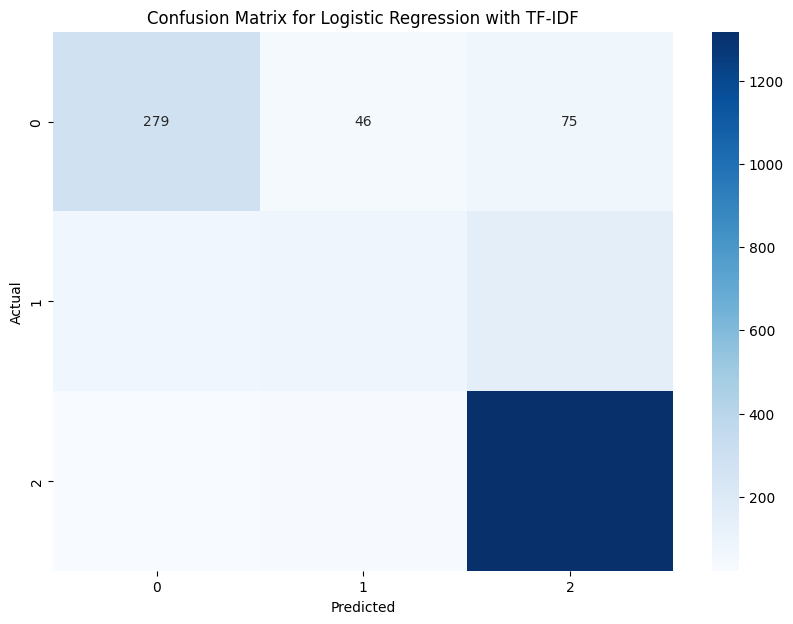

Vectorizer: Count Vectorizer, Ngram, Classifier: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71       400
     neutral       0.49      0.34      0.40       306
    positive       0.87      0.95      0.91      1369

    accuracy                           0.81      2075
   macro avg       0.70      0.66      0.67      2075
weighted avg       0.79      0.81      0.79      2075



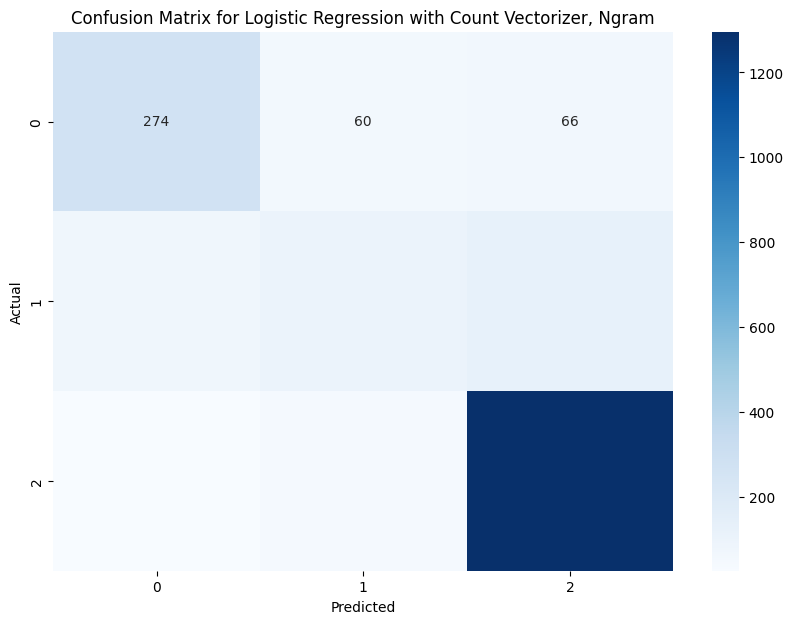

In [18]:
print_best_models_reports(results)

## Calculating Polarity, Subjectivity 


In [19]:
from textblob import TextBlob
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()


Unnamed: 0  stars                                               text  \
0     2370338      5  get food poison palm hotel scare eat buffet fi...   
1     2370357      4  feast worthi god baccarn buffet caesar palac c...   
2     2370373      4  crab leg better one wick spoon huge prawn shee...   
3     2370411      1    worth salti food expens furst kast visit buffet   
4     2370500      5  would give infinit star could famili diamond c...   

  language                                     tokenized_text sentiment_type  \
0       en  [get, food, poison, palm, hotel, scare, eat, b...       positive   
1       en  [feast, worthi, god, baccarn, buffet, caesar, ...       positive   
2       en  [crab, leg, better, one, wick, spoon, huge, pr...       positive   
3       en  [worth, salti, food, expens, furst, kast, visi...       negative   
4       en  [would, give, infinit, star, could, famili, di...       positive   

   polarity  subjectivity  
0  0.338333      0.525952  
1  0.240502      0.548495  
2  0.247619      0.569048  
3  0.300000      0.100000  
4  0.483333      0.633333

<Axes: >

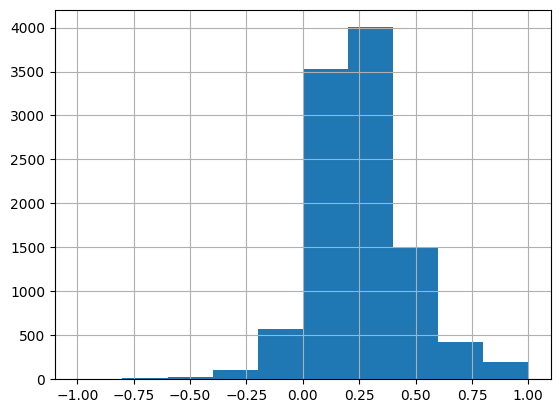

In [20]:
df.polarity.hist()

<Axes: >

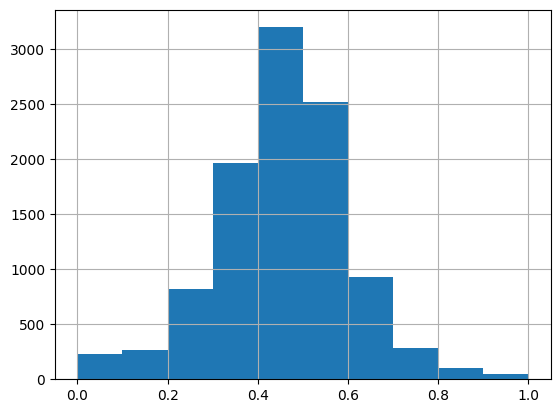

In [21]:
df.subjectivity.hist()

In [22]:
df['sentiment_acc_polarity'] = df['polarity'].apply(lambda x: 'positive' if x > 0.3 else ('negative' if x < -0.1 else 'neutral'))
df.head()

Unnamed: 0  stars                                               text  \
0     2370338      5  get food poison palm hotel scare eat buffet fi...   
1     2370357      4  feast worthi god baccarn buffet caesar palac c...   
2     2370373      4  crab leg better one wick spoon huge prawn shee...   
3     2370411      1    worth salti food expens furst kast visit buffet   
4     2370500      5  would give infinit star could famili diamond c...   

  language                                     tokenized_text sentiment_type  \
0       en  [get, food, poison, palm, hotel, scare, eat, b...       positive   
1       en  [feast, worthi, god, baccarn, buffet, caesar, ...       positive   
2       en  [crab, leg, better, one, wick, spoon, huge, pr...       positive   
3       en  [worth, salti, food, expens, furst, kast, visi...       negative   
4       en  [would, give, infinit, star, could, famili, di...       positive   

   polarity  subjectivity sentiment_acc_polarity  
0  0.338333      0.525952               positive  
1  0.240502      0.548495                neutral  
2  0.247619      0.569048                neutral  
3  0.300000      0.100000                neutral  
4  0.483333      0.633333               positive

## Calculating Pos, Neg, Neu, Compound 


In [23]:


from nltk.sentiment.vader import SentimentIntensityAnalyzer # VADER sentiment analysis
nltk.download('vader_lexicon') # download the VADER lexicon
sia = SentimentIntensityAnalyzer() # create a VADER sentiment analysis object

def get_vader_sentiment(text): # function to get the sentiment using VADER

    sentiment = sia.polarity_scores(text) # get the polarity scores for the text
    
    if sentiment['compound'] >= 0.05: # if the compound score is positive
        return 'positive' # return positive
    elif sentiment['compound'] <= -0.05: # if the compound score is negative
        return 'negative'
    else:
        return 'neutral' # otherwise return neutral
    
df['sentiment_vader'] = df['text'].apply(get_vader_sentiment) # get the sentiment using VADER
df.head() # display the first few rows of the data


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bugra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Unnamed: 0  stars                                               text  \
0     2370338      5  get food poison palm hotel scare eat buffet fi...   
1     2370357      4  feast worthi god baccarn buffet caesar palac c...   
2     2370373      4  crab leg better one wick spoon huge prawn shee...   
3     2370411      1    worth salti food expens furst kast visit buffet   
4     2370500      5  would give infinit star could famili diamond c...   

  language                                     tokenized_text sentiment_type  \
0       en  [get, food, poison, palm, hotel, scare, eat, b...       positive   
1       en  [feast, worthi, god, baccarn, buffet, caesar, ...       positive   
2       en  [crab, leg, better, one, wick, spoon, huge, pr...       positive   
3       en  [worth, salti, food, expens, furst, kast, visi...       negative   
4       en  [would, give, infinit, star, could, famili, di...       positive   

   polarity  subjectivity sentiment_acc_polarity sentiment_vader  
0  0.338333      0.525952               positive        positive  
1  0.240502      0.548495                neutral        positive  
2  0.247619      0.569048                neutral        positive  
3  0.300000      0.100000                neutral        positive  
4  0.483333      0.633333               positive        positive

## WordCloud 

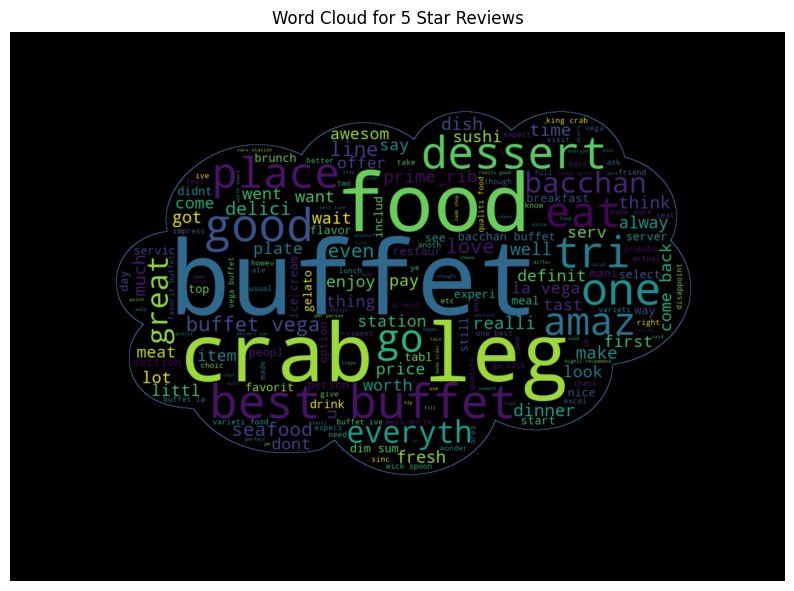

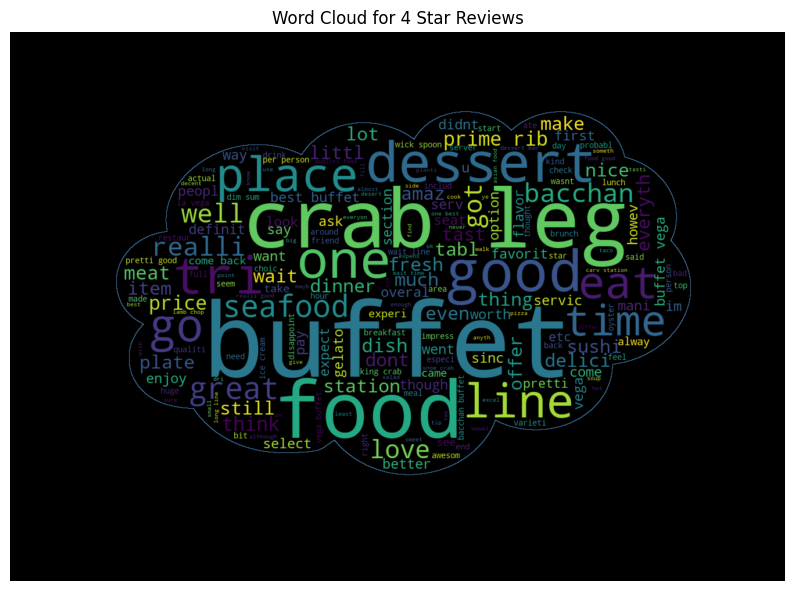

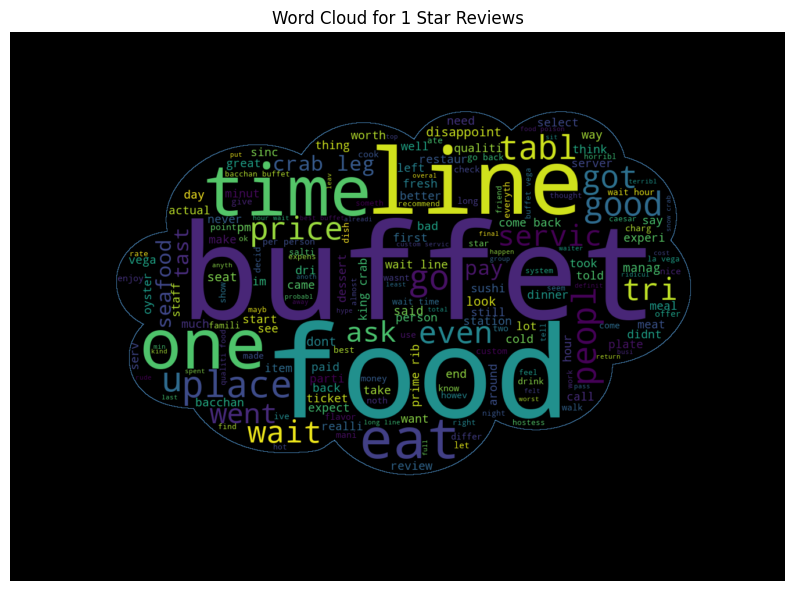

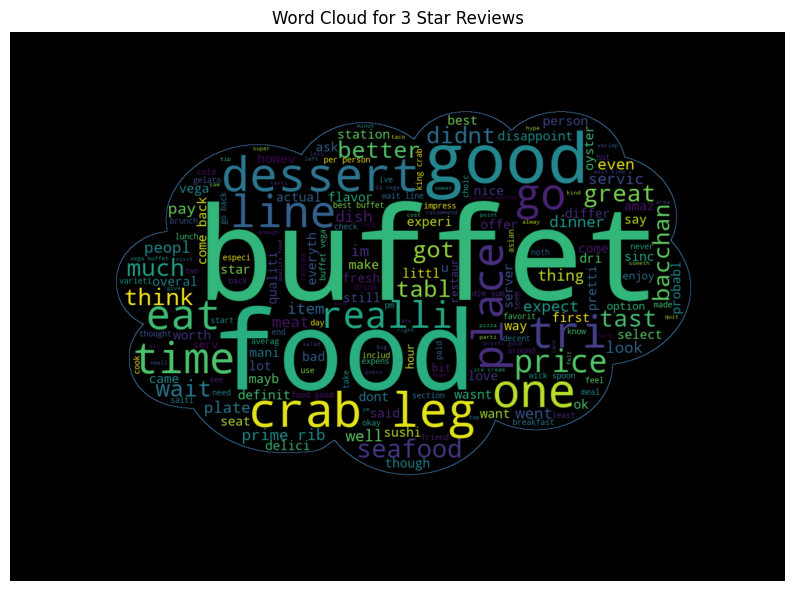

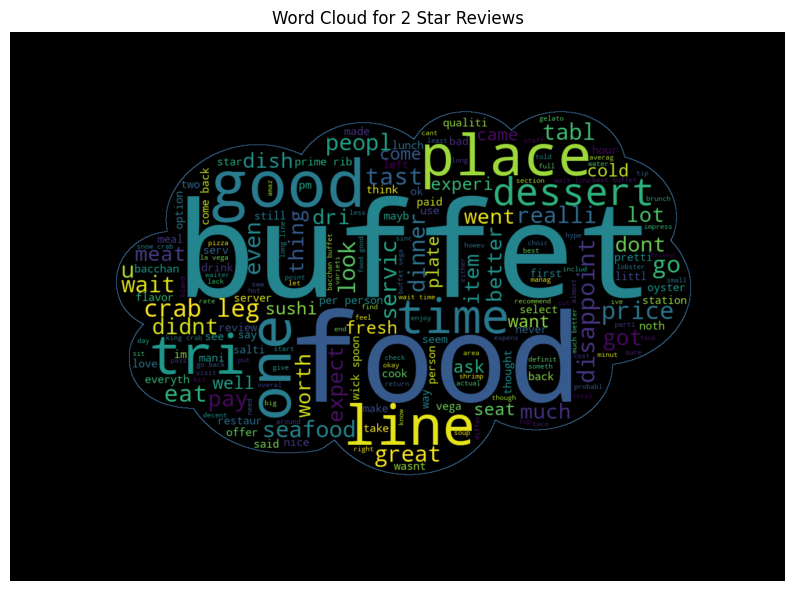

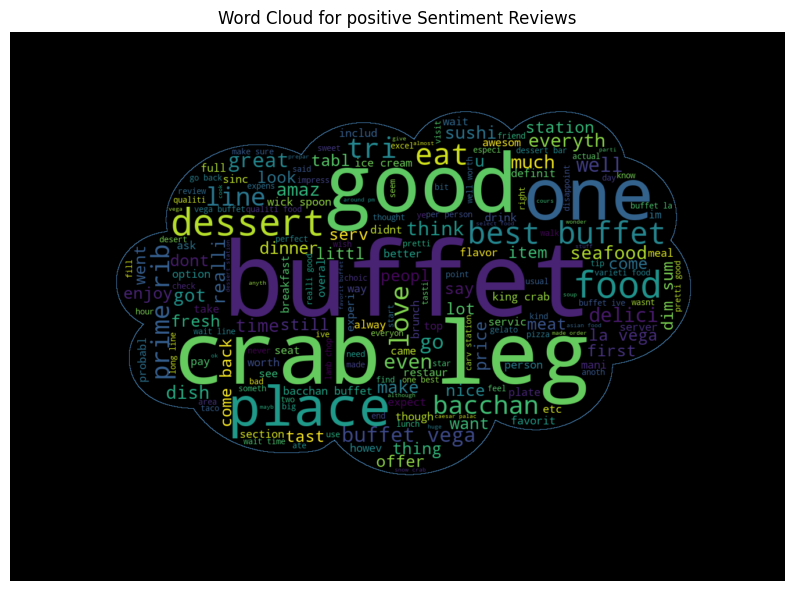

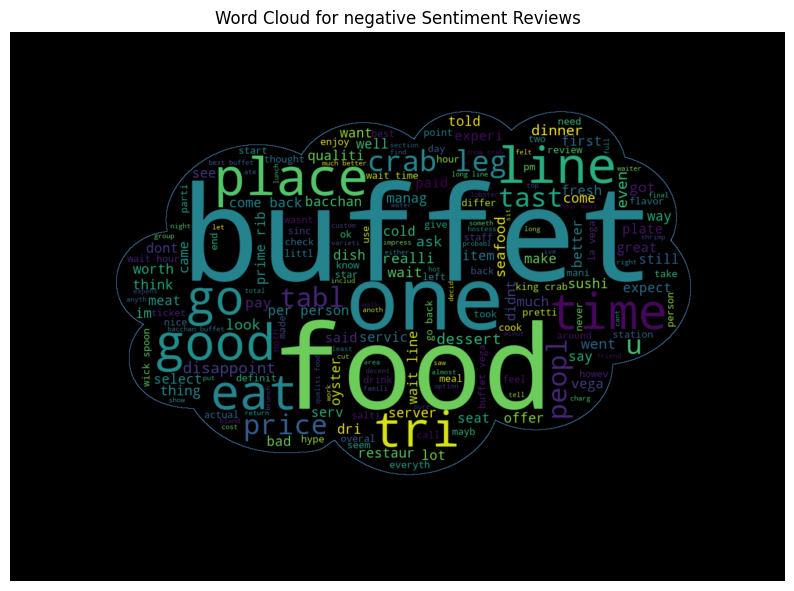

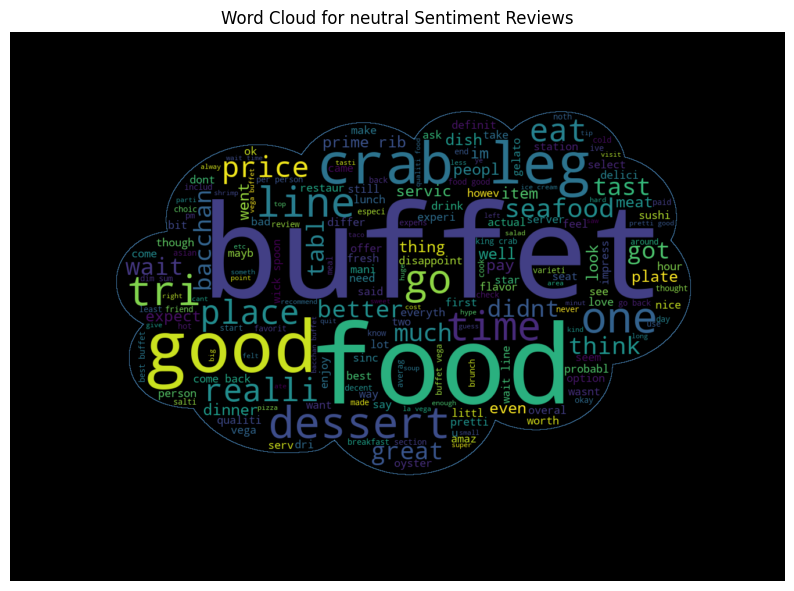

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

cloud_mask = np.array(Image.open('cloud.png'))

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, max_words=200, mask=cloud_mask, contour_width=1, contour_color='steelblue').generate(text)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for star in df['stars'].unique():
    text = ' '.join(df[df['stars'] == star]['text'])
    plot_wordcloud(text, f'Word Cloud for {star} Star Reviews')

# wordcloud for each sentiment type
for sentiment in df['sentiment_type'].unique():
    text = ' '.join(df[df['sentiment_type'] == sentiment]['text'])
    plot_wordcloud(text, f'Word Cloud for {sentiment} Sentiment Reviews')

### Some of the words are not meaningful, we can remove them from the wordcloud

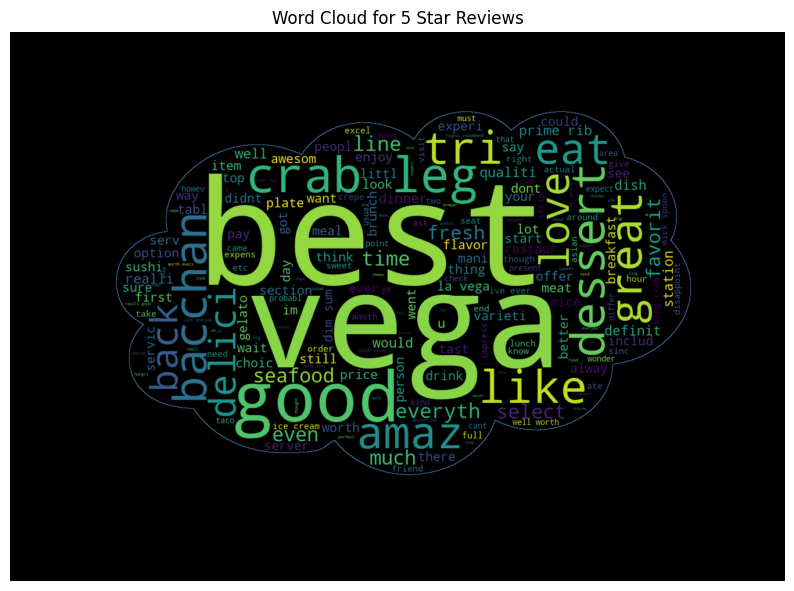

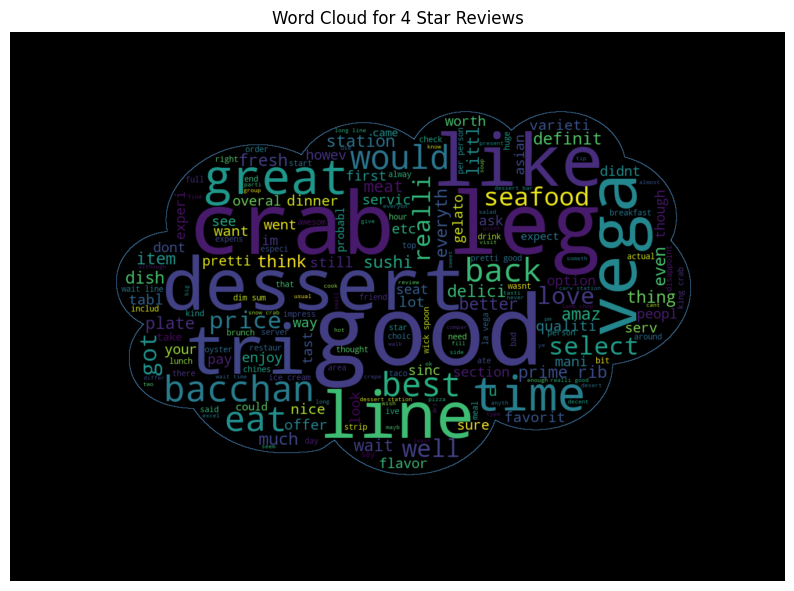

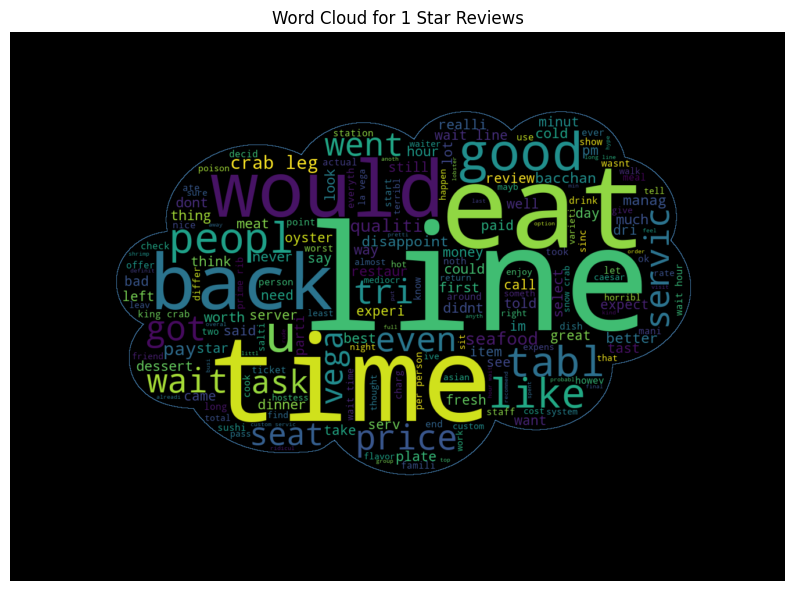

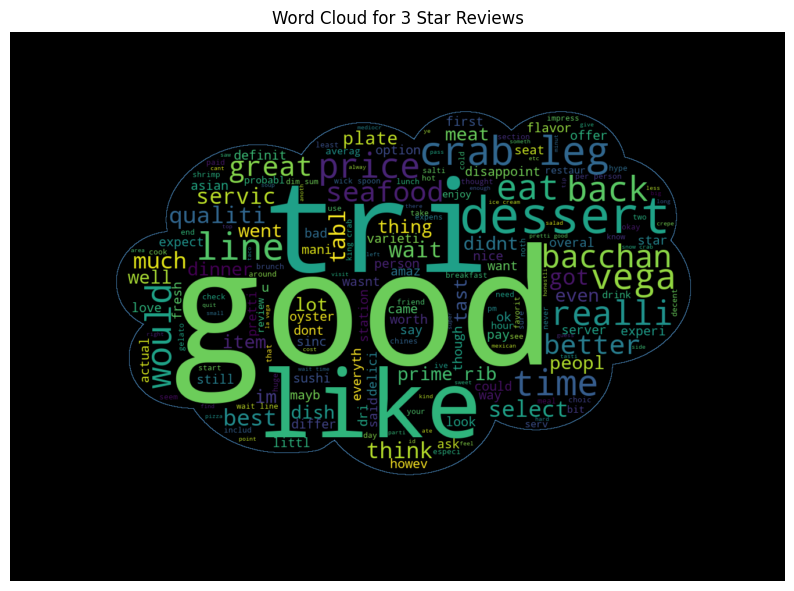

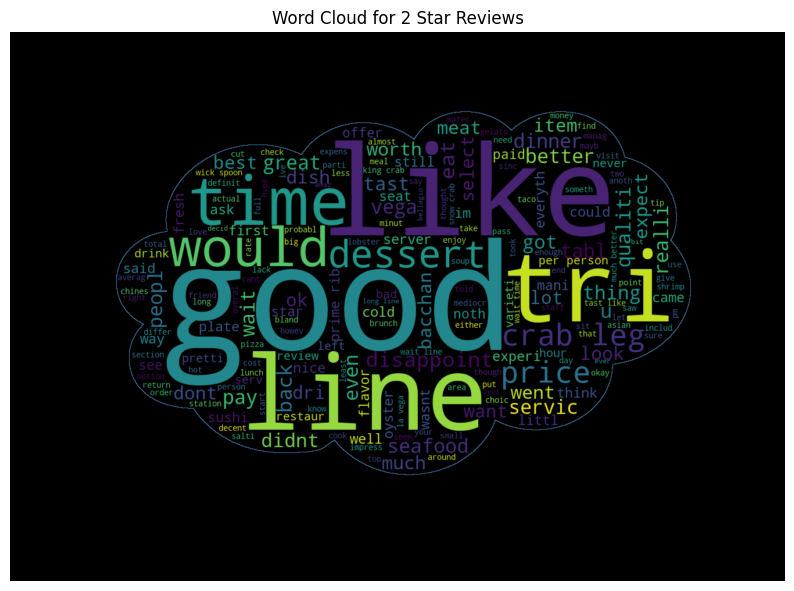

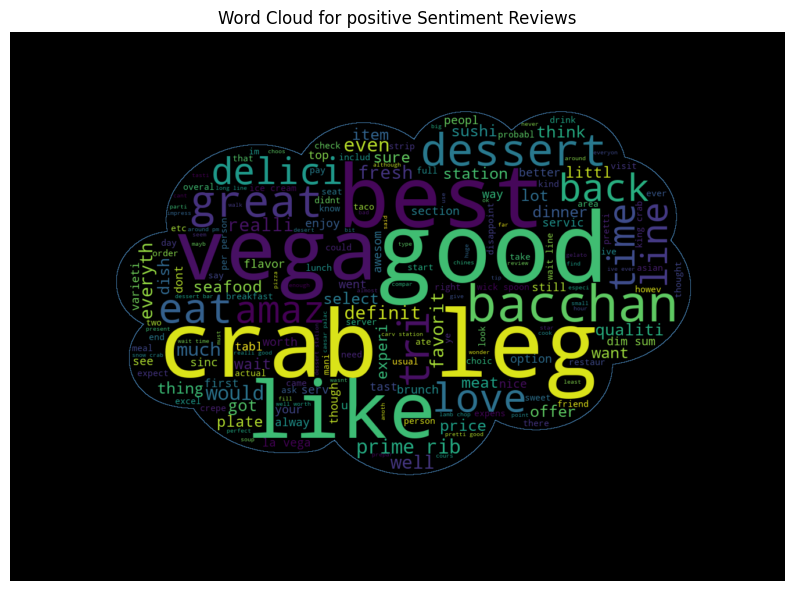

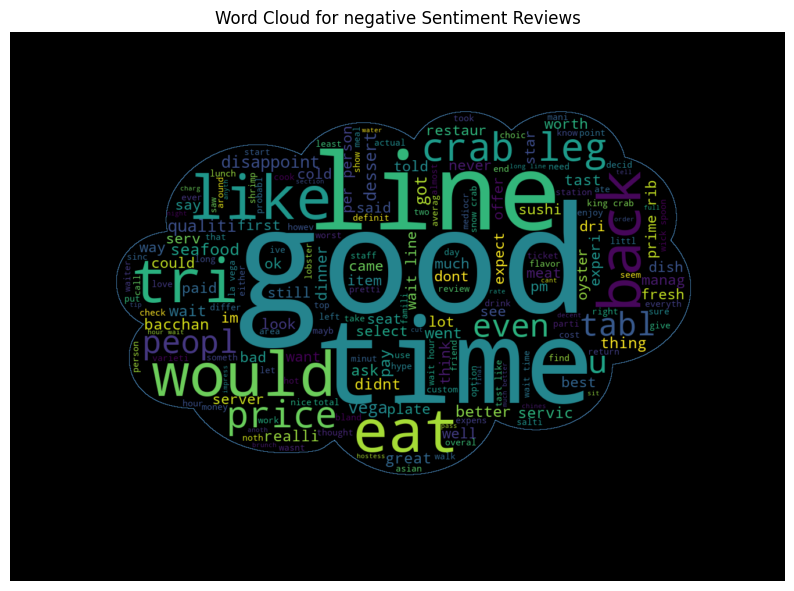

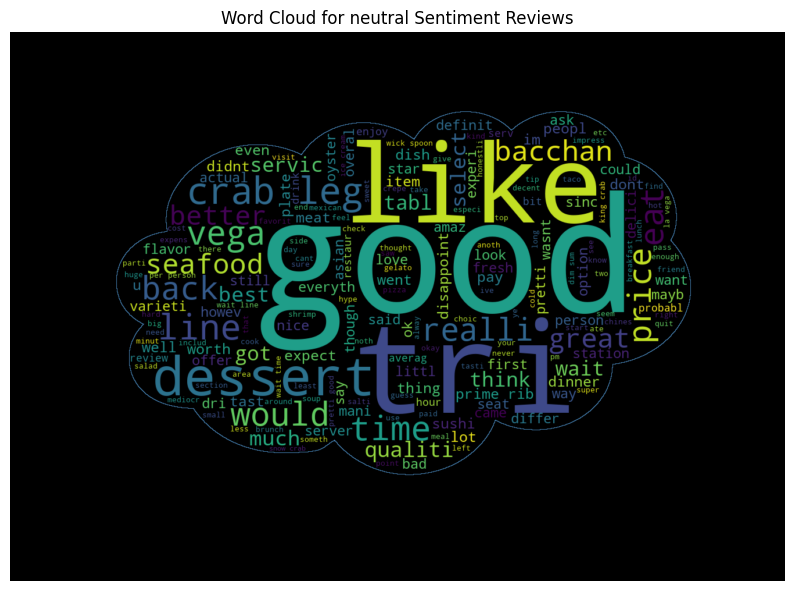

In [25]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

cloud_mask = np.array(Image.open('cloud.png'))

custom_stopwords = ["buffet","food","restaurant" , "place", "one", "try","make","come","get", "made","go", "also"]

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, max_words=200, mask=cloud_mask, contour_width=1, contour_color='steelblue', stopwords=set(custom_stopwords)).generate(text)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# wordcloud for each star
for star in df['stars'].unique():
    text = ' '.join(df[df['stars'] == star]['text'])
    plot_wordcloud(text, f'Word Cloud for {star} Star Reviews')

# wordcloud for each sentiment type
for sentiment in df['sentiment_type'].unique():
    text = ' '.join(df[df['sentiment_type'] == sentiment]['text'])
    plot_wordcloud(text, f'Word Cloud for {sentiment} Sentiment Reviews')

In [26]:
# Positive 2 words & 3 words

from collections import Counter

def get_most_common_words(text, n=10):
    words = text.split()
    return Counter(words).most_common(n)

positive_text = ' '.join(df[df['sentiment_type'] == 'positive']['text'])
positive_words = get_most_common_words(positive_text, 10)
positive_words


[('buffet', 11930),
 ('food', 7992),
 ('good', 4805),
 ('vega', 4014),
 ('wait', 4001),
 ('dessert', 3942),
 ('get', 3897),
 ('time', 3863),
 ('crab', 3841),
 ('line', 3727)]

In [27]:
#negative 2 words & 3 words
negative_text = ' '.join(df[df['sentiment_type'] == 'negative']['text'])
negative_words = get_most_common_words(negative_text, 10)
negative_words


[('buffet', 2944),
 ('food', 2829),
 ('wait', 1774),
 ('line', 1747),
 ('get', 1490),
 ('time', 1308),
 ('good', 1284),
 ('crab', 1132),
 ('like', 1097),
 ('go', 1041)]

In [28]:
# top 5 complaints
complaints = negative_text.split()
complaints = [word for word in complaints if len(word) > 2]
complaints = [word for word in complaints if word.lower() not in stopwords_set]
complaints = [word for word in complaints if word.isalpha()]
complaints = Counter(complaints)
complaints.most_common(5)


[('buffet', 2944),
 ('food', 2829),
 ('wait', 1774),
 ('line', 1747),
 ('get', 1490)]

In [29]:
#top 5 positive words
positive_text = ' '.join(df[df['sentiment_type'] == 'positive']['text'])
positive_text = positive_text.split()   
positive_text = [word for word in positive_text if len(word) > 2]
positive_text = [word for word in positive_text if word.lower() not in stopwords_set]
positive_text = [word for word in positive_text if word.isalpha()]
positive_text = Counter(positive_text)
positive_text.most_common(5)


[('buffet', 11930),
 ('food', 7992),
 ('good', 4805),
 ('vega', 4014),
 ('wait', 4001)]

In [30]:
import pandas as pd
from nltk import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

# Positive words
positive_words = set(["wonderful", "excellent", "friendly", "helpful", "pleasing"])

#find ngrams
def find_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    n_grams = ngrams(tokens, n)
    return list(n_grams)

# Filter positive ngrams
def filter_positive_ngrams(ngrams_list, positive_words):
    positive_ngrams = [ngram for ngram in ngrams_list if any(word in positive_words for word in ngram)]
    return positive_ngrams

# create empty lists for bigrams and trigrams
all_bigrams = []
all_trigrams = []


# Find bigrams and trigrams for each text
for text in df['text']:
    bigrams = find_ngrams(text, 2)
    trigrams = find_ngrams(text, 3)
    
    positive_bigrams = filter_positive_ngrams(bigrams, positive_words)
    positive_trigrams = filter_positive_ngrams(trigrams, positive_words)
    
    all_bigrams.extend(positive_bigrams)
    all_trigrams.extend(positive_trigrams)


bigram_counts = Counter(all_bigrams)
trigram_counts = Counter(all_trigrams)


bigram_df = pd.DataFrame(bigram_counts.items(), columns=['Bigram', 'Count']).sort_values(by='Count', ascending=False).head(10)
trigram_df = pd.DataFrame(trigram_counts.items(), columns=['Trigram', 'Count']).sort_values(by='Count', ascending=False).head(10)

# Print the results
print("Pozitif Bigramlar:")
print(bigram_df.head(10))

print("\nPozitif Trigramlar:")
print(trigram_df.head(10))

Pozitif Bigramlar:
               Bigram  Count
0     (nice, helpful)      1
1  (helpful, dessert)      1
2   (realli, helpful)      1
3    (helpful, would)      1
4   (thatsh, helpful)      1
5     (helpful, nice)      1

Pozitif Trigramlar:
                     Trigram  Count
0       (guy, nice, helpful)      1
1   (nice, helpful, dessert)      1
2  (helpful, dessert, excel)      1
3    (work, realli, helpful)      1
4   (realli, helpful, would)      1
5      (helpful, would, say)      1
6     (see, thatsh, helpful)      1
7    (thatsh, helpful, nice)      1
8     (helpful, nice, thing)      1


In [31]:
import pandas as pd
from nltk import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

negative_words = set(["bad", "terrible", "awful", "poor", "horrible"])

def find_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def filter_negative_ngrams(ngrams_list, negative_words):
    negative_ngrams = [ngram for ngram in ngrams_list if any(word in negative_words for word in ngram)]
    return negative_ngrams

all_bigrams = []
all_trigrams = []



for text in df['text']:
    bigrams = find_ngrams(text, 2)
    trigrams = find_ngrams(text, 3)
    
    negative_bigrams = filter_negative_ngrams(bigrams, negative_words)
    negative_trigrams = filter_negative_ngrams(trigrams, negative_words)
    
    all_bigrams.extend(negative_bigrams)
    all_trigrams.extend(negative_trigrams)

bigram_counts = Counter(all_bigrams)
trigram_counts = Counter(all_trigrams)

bigram_df = pd.DataFrame(bigram_counts.items(), columns=['Ngram', 'Count']).sort_values(by='Count', ascending=False).head(10)
trigram_df = pd.DataFrame(trigram_counts.items(), columns=['Ngram', 'Count']).sort_values(by='Count', ascending=False).head(10)

print("Negatif Bigramlar:")
print(bigram_df)

print("\nNegatif Trigramlar:")
print(trigram_df)

Negatif Bigramlar:
             Ngram  Count
4     (wasnt, bad)    138
17   (realli, bad)     45
142   (bad, thing)     38
100    (food, bad)     34
10   (bad, experi)     33
30   (bad, servic)     33
39     (isnt, bad)     31
81     (bad, food)     30
219     (bad, day)     28
109    (feel, bad)     24

Negatif Trigramlar:
                       Ngram  Count
93        (wait, wasnt, bad)     36
385       (line, wasnt, bad)     12
400       (food, wasnt, bad)     11
790       (bad, tast, mouth)      8
1702   (qualiti, food, poor)      7
828    (poor, qualiti, food)      7
364      (food, bad, servic)      7
679   (poor, custom, servic)      6
1872      (wasnt, bad, line)      6
1654        (mayb, bad, day)      6


## Conclusion

In this notebook, we analyzed Yelp restaurant reviews. We cleaned the data, removing non-English reviews and unnecessary characters. Text preprocessing included stemming, lemmatization, and tokenization. Sentiment analysis classified reviews into positive, negative, and neutral categories. We evaluated various machine learning models to find the best sentiment classifier. Finally, we calculated the polarity and subjectivity of the reviews. This analysis helps understand customer sentiments and improve restaurant services based on feedback.